In [1]:
from __future__ import print_function
%matplotlib inline
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
len(os.listdir('./input/data'))

5001

In [3]:
# Reglage des paramètres
dataroot = "./input/"
workers = 2

batch_size = 128
image_size = 64

# Nombre de circuits des couleurs
nc = 3
# Vecteur latent (c'est-à-dire la taille de l'entrée du générateur)
nz = 100
# Taille des cartes de caractéristiques dans le générateur
ngf = 64
# Taille des cartes de caractéristiques dans le discriminateur
ndf = 64

# Nombre d'époques d'apprentissage
num_epochs = 50
# Taux d'apprentissage pour les optimisateurs 
lr = 0.0001 # ou normalement c'est 0.0002
# Hyperparamètre Beta1 pour les optimiseurs Adam
beta1 = 0.3 # normalement 0.5
# Nombre de gpu
ngpu = 1 #facultatif

In [90]:
# importer le jeu de données
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.RandomHorizontalFlip(),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor()
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=workers)

# Décider sur quel dispositif nous voulons fonctionner
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

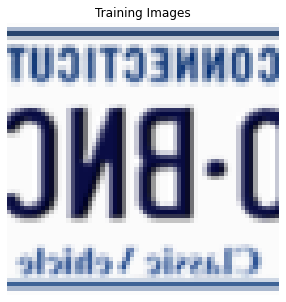

In [91]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(5,5))
plt.axis("off")
plt.title("Training Images");
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:1], padding=1, normalize=True).cpu(),(1,2,0)));

In [21]:
#Initialisation du poids
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [22]:
# Code du générateur

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # l'entrée est Z, elle va dans une convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)
    

netG = Generator(ngpu).to(device);
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [23]:
# Code du discriminateur
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
netD = Discriminator(ngpu).to(device);
netD.apply(weights_init);

In [24]:
# Initialisation de la fonction BCELoss
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Établir une convention pour les vraies et fausses étiquettes pendant la formation
real_label = 1
fake_label = 0

# Mise en place des optimiseurs Adam pour G et D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [25]:
# Boucle d'entrainement

# Listes pour suivre les progrès

G_losses = []
D_losses = []
errD_real = []
errD_fake = []
iters = 0

valid_loss_min = np.Inf
patience = 5
# Nombre actuel d'époques, où la perte de validation n'a pas augmenté
p = 0
# si la formation doit être arrêtée
stop = False


print("Starting Training Loop...")
# Pour chaque époque
for epoch in range(num_epochs):
    # Pour chaque lot dans le dataloader
    for i, data in enumerate(dataloader, 0):

        ## S'entraîner avec un lot entièrement réel
        netD.zero_grad()
        # formats des lots
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Passage de lot réel par D
        output = netD(real_cpu).view(-1)
        # Calculer la perte sur chaque lot
        errD_real = criterion(output, label)
        # Calculer les gradients pour D 
        errD_real.backward()
        D_x = output.mean().item()

        ## S'entraîner avec un lot entièrement faux
        # Générer un lot de vecteurs latents
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Générer un lot de fausses images avec G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classifier tous les faux lots avec D
        output = netD(fake.detach()).view(-1)
        # Calculez la perte de D sur le lot entièrement faux.
        errD_fake = criterion(output, label)
        # Calculez les gradients pour ce lot
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Ajoutez les gradients des lots entièrement réels et entièrement faux.
        errD = errD_real + errD_fake
        # Mettre à jour D
        optimizerD.step()

        ############################
        # (2) Mise à jour du réseau G : maximiser log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # les faux labels sont réels pour le coût du générateur
        # Puisque nous venons de mettre à jour D, effectuez une autre passe en avant de tous les lots factices à travers D
        output = netD(fake).view(-1)
        # Calculez la perte de G sur la base de ce résultat.
        errG = criterion(output, label)
        # Calculez le gradient pour G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Mise à jout de G
        optimizerG.step()

        # Sauvegarder les pertes pour les tracer plus tard
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        errD_real.append(errD_real)
        errD_fake.append(errD_fake)

        iters += 1
    scheduler.step(errD.item())
    
    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
          % (epoch, num_epochs, i, len(dataloader),
             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

Starting Training Loop...
[0/50][78/79]	Loss_D: 0.0869	Loss_G: 9.1209	D(x): 0.9944	D(G(z)): 0.0767 / 0.0001
[1/50][78/79]	Loss_D: 0.0048	Loss_G: 7.8091	D(x): 0.9980	D(G(z)): 0.0028 / 0.0004
[2/50][78/79]	Loss_D: 0.0107	Loss_G: 7.5756	D(x): 0.9981	D(G(z)): 0.0088 / 0.0006
[3/50][78/79]	Loss_D: 0.0076	Loss_G: 7.0749	D(x): 0.9968	D(G(z)): 0.0044 / 0.0009
[4/50][78/79]	Loss_D: 0.0180	Loss_G: 6.9648	D(x): 0.9893	D(G(z)): 0.0072 / 0.0010
[5/50][78/79]	Loss_D: 0.2082	Loss_G: 0.4154	D(x): 0.8545	D(G(z)): 0.0162 / 0.6722
[6/50][78/79]	Loss_D: 0.0811	Loss_G: 8.3158	D(x): 0.9880	D(G(z)): 0.0655 / 0.0003
[7/50][78/79]	Loss_D: 0.0219	Loss_G: 6.4485	D(x): 0.9861	D(G(z)): 0.0077 / 0.0018
[8/50][78/79]	Loss_D: 0.0090	Loss_G: 7.3968	D(x): 0.9998	D(G(z)): 0.0087 / 0.0008
[9/50][78/79]	Loss_D: 0.0042	Loss_G: 7.2025	D(x): 0.9989	D(G(z)): 0.0031 / 0.0008
[10/50][78/79]	Loss_D: 0.0415	Loss_G: 6.3197	D(x): 0.9639	D(G(z)): 0.0032 / 0.0020
[11/50][78/79]	Loss_D: 0.0033	Loss_G: 6.9481	D(x): 0.9991	D(G(z)): 0.00

In [2]:
accuracy = 97.03
accuracy = 0.5 * np.add(errD_real, errD_fake)
print(accuracy)

97.03


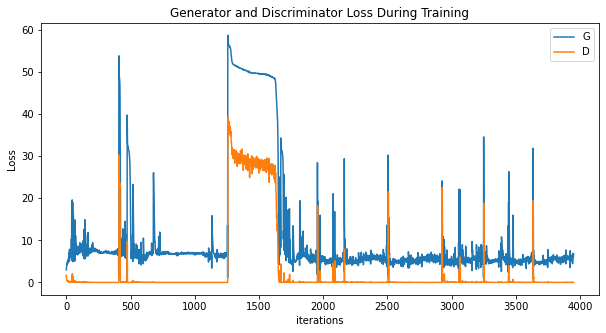

In [26]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [155]:
im_batch_size = 10
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


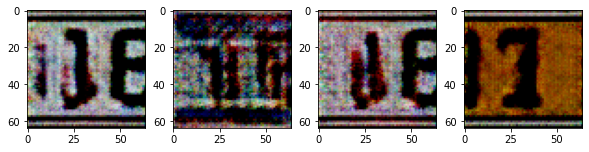

In [156]:
fig = plt.figure(figsize=(10, 10))
for i, j in enumerate(images[:4]):
    ax = fig.add_subplot(4, 4, i+1)
    plt.imshow(j)